In [133]:
#Standard libraries
import pandas as pd
import numpy as np
from datetime import datetime
import math

#plotting
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches

plt.style.use('seaborn-darkgrid')
%matplotlib inline

FIG_SIZE = (13,6)

# Analysing member data

In [134]:
user_df = pd.read_csv("filestore/user/fact_user_dataset.csv").drop('Unnamed: 0',axis=1)
topics_df = pd.read_csv("filestore/user/dim_topics.csv").drop('Unnamed: 0',axis=1)

# There seems to be a user with joined = nan, filter them out
user_df = user_df[~user_df['joined'].isnull()]

In [135]:
def convert_posix_time(t):
    return datetime.utcfromtimestamp(t / 1000)

In [136]:
user_df['joined'] = user_df['joined'].apply(convert_posix_time)
user_df['visited'] = user_df['visited'].apply(convert_posix_time)

In [137]:
user_df.head()

,bio,city,country,hometown,user_id,joined,lat,link,lon,name,state,status,topics,visited
0,Engineer working at Etsy,Dublin,ie,NaN,203627719,2017-04-18 22:36:19,53.33,http://www.meetup.com/members/203627719,-6.25,Niamh Donnelly,NaN,active,15236,2019-02-19 14:48:46
1,NaN,Anyang,kr,NaN,236920397,2018-01-10 10:55:54,37.39,http://www.meetup.com/members/236920397,126.92,A Yeon Choi,NaN,active,"50881,563,26212,67622,48471,3833",2018-01-10 10:55:54
2,NaN,Dublin,ie,NaN,202430831,2019-03-23 10:51:08,53.33,http://www.meetup.com/members/202430831,-6.25,Aakanksha Rana,NaN,active,"59430,18551,65780,8476,48471,108403,682,9696,563",2019-04-08 07:36:11
3,NaN,Paris,fr,NaN,129312012,2016-02-12 22:08:19,48.86,http://www.meetup.com/members/129312012,2.34,abdobim,NaN,active,"189,2260,16216,20346,21441,51642,9696,10306,10...",2016-02-14 21:20:05
4,NaN,Dublin,ie,NaN,242392259,2017-11-28 17:14:11,53.33,http://www.meetup.com/members/242392259,-6.25,Abheri Dutta,NaN,active,"9696,15236,1924,8476,223,6144,39173,9349,206,1...",2018-06-19 10:58:20


In [138]:
user_df.dtypes

bio                 object
city                object
country             object
hometown            object
user_id              int64
joined      datetime64[ns]
lat                float64
link                object
lon                float64
name                object
state               object
status              object
topics              object
visited     datetime64[ns]
dtype: object

In [139]:
topics_df.head()

,urlkey,name,topic_id,target
0,business-networking,professional-networking,15236,pyladiesdublin
1,international-friends,International Friends,50881,pyladiesdublin
2,opensource,Open Source,563,pyladiesdublin
3,language-exchange,Language Exchange,26212,pyladiesdublin
4,culture-exchange,Culture Exchange,67622,pyladiesdublin


### When did members start joining?

In [140]:
user_df['joined_month'] = user_df['joined'].apply(lambda t: t.month)
user_df['joined_year'] = user_df['joined'].apply(lambda t: t.year)

In [141]:
months = range(1,13)
month_count = user_df.groupby(['joined_month'])['joined_month'].count().tolist()
years = range(2013, 2020)
year_count = user_df.groupby(['joined_year'])['joined_year'].count().tolist()

In [142]:
y_max = max(year_count) +2

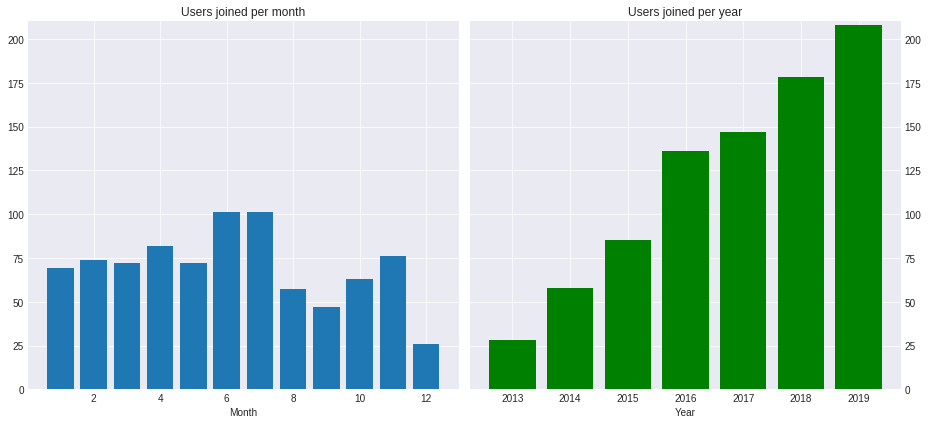

In [143]:
fig, (month_axis, year_axis) = plt.subplots(nrows=1, ncols=2, figsize=FIG_SIZE)
month_axis.bar(
    x=months,
    height=month_count
)
month_axis.set_title("Users joined per month")
month_axis.set_xlabel("Month")
month_axis.set_ylim(ymax = y_max)

year_axis.bar(
    x=years,
    height=year_count,
    color = 'g'
)
year_axis.set_title("Users joined per year")
year_axis.set_xlabel("Year")
year_axis.set_ylim(ymax = y_max)
year_axis.yaxis.tick_right()

plt.style.use('seaborn-darkgrid')
fig.tight_layout()

#### Summer months are the most popular for people to join and the # of s joined  seems to be growing linearly. How does this behave over the full existence of the group?

Create a grouping variable

In [144]:
user_df['joined_month_year'] = (
    user_df['joined']
    .apply(lambda t: str(t.month) + "-" + str(t.year))
)

In [145]:
month_year_count = user_df.groupby(['joined_year', 'joined_month'])['joined_month'].count().tolist()
month_year_df = (
    user_df[['joined_year','joined_month', 'joined_month_year']]
    .drop_duplicates()
    .sort_values(['joined_year','joined_month'])
)
month_year_df.head()

,joined_year,joined_month,joined_month_year
55,2013,10,10-2013
18,2013,11,11-2013
725,2013,12,12-2013
21,2014,1,1-2014
20,2014,2,2-2014


The next cell assigns a colour to each year

In [146]:
color_map = cm.get_cmap('tab10')
color_list = [color_map(i/float(len(years))) for i in range(len(years))] # years defined above

month_year_df['color'] = (
    month_year_df['joined_year']
    .apply(lambda y: color_list[y % min(years)])
)
month_year_color = month_year_df['color'].tolist()

In [147]:
# Color patches allow for custom legends
color_patch_list = [mpatches.Patch(color=c, label=y) for c,y in zip(color_list, years)]

Exploring some population growth

In [148]:
cumulative_member_count = np.cumsum(month_year_count)

init_pop = cumulative_member_count[0]
rog = np.mean([new_count/total for new_count, total in zip(month_year_count, cumulative_member_count)])
e = math.e

malthusian_growth = [init_pop*math.pow(e, rog*time) for time in range(len(month_year_color))]

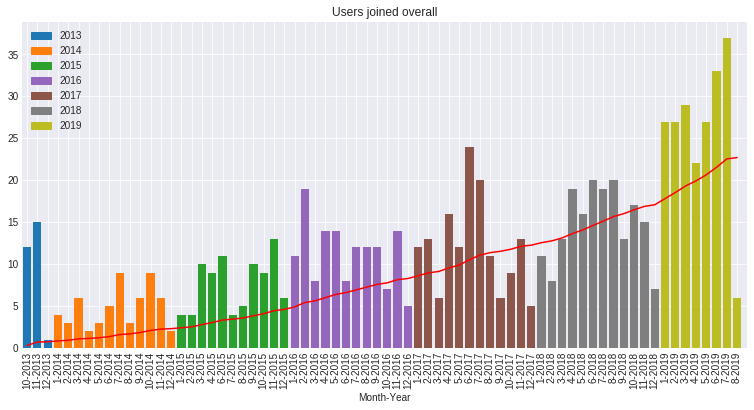

In [149]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.bar(
    x = month_year_df['joined_month_year'],
    height = month_year_count,
    color = month_year_color
)
ax.set_title("Users joined overall")
ax.set_xlabel("Month-Year")
ax.legend(handles=color_patch_list, loc='upper left', fancybox=True)

ax.plot(
    cumulative_member_count/max(month_year_count), 
    c='r'
)
ax.set_xlim(xmin=-0.5, xmax=len(month_year_df['joined_month_year']))

plt.xticks(month_year_df['joined_month_year'], rotation=90)
plt.style.use('seaborn-darkgrid')
plt.show()

It seems that the group presents some form of exponential (malthusian) growth, pretty cool!
Here's how large the group would be if it presented uniform growth rate:

In [150]:
print(f'Growth rate {rog*100:0.2f}%')

Growth rate 6.96%


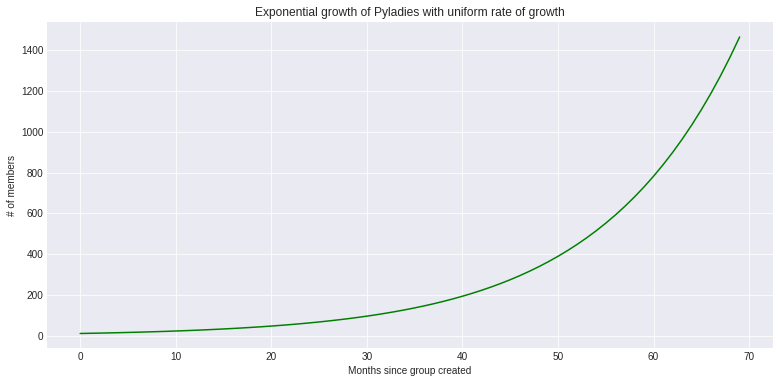

In [151]:
fig, ax = plt.subplots(figsize = FIG_SIZE)
ax.plot(malthusian_growth, c='g')
ax.set_xlabel('Months since group created')
ax.set_ylabel('# of members')
ax.set_title('Exponential growth of Pyladies with uniform rate of growth')

plt.style.use('seaborn-darkgrid')
plt.show()

## Some profiling of the group

In [152]:
user_df['status'].unique().tolist()

['active']

# Other things to explore:

In [153]:
def top_n_barplot(df, col, start=0, end=15, rot=45):
    data = df[col].value_counts()[start:end]
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    x = data.index.tolist()
    
    ax.bar(x=x, height=data)
    ax.set_xlim(xmin=-0.5, xmax=len(x))
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

    bar_list = ax.patches
    for bar, label in zip(bar_list, data):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, label,
                ha='center', va='bottom')

    plt.xticks(rotation=rot)
    plt.style.use('seaborn-darkgrid')
    plt.show()

In [154]:
string_cols = [idx for c, idx in zip(user_df.dtypes, user_df.dtypes.index) if c=='object']

In [155]:
string_cols

['bio',
 'city',
 'country',
 'hometown',
 'link',
 'name',
 'state',
 'status',
 'topics',
 'joined_month_year']

## Most common Country / Hometowns

In [157]:
iso3_list = ['ARG', 'AUS', 'BEL', 'BRA', 'CAN', 'CHE', 'CHL', 'CZE', 'DEU', 'ESP', 'FRA',\
            'GBR', 'HUN', 'IRL', 'IND', 'JPN', 'KOR', 'LTU', 'NLD', 'NZL', 'POL', 'PRT', \
            'ROU', 'SWE', 'THA', 'TUR', 'UAE', 'USA']
iso2_map = {
    iso2:iso3 
    for iso2, iso3 
    in zip(sorted(user_df['country'].unique()), iso3_list)
}

user_df['country'] = user_df['country'].apply(lambda c: iso2_map[c])

In [185]:
country_count = pd.DataFrame(
    user_df['country']
    .value_counts()
    .rename('count')) \
    .reset_index()
no_irl = country_count[country_count['index']!='IRL']

Ireland has too many respondents, so the plot doesn't look as informative with it, if we remove it we get more information

In [193]:
fig = px.choropleth(no_irl, locations="index",
                     hover_name="index", color="count",
                     color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [189]:
user_df['hometown'] = (
    user_df['hometown']
    .str.upper()
    .str.replace(r',.+$', '')
)

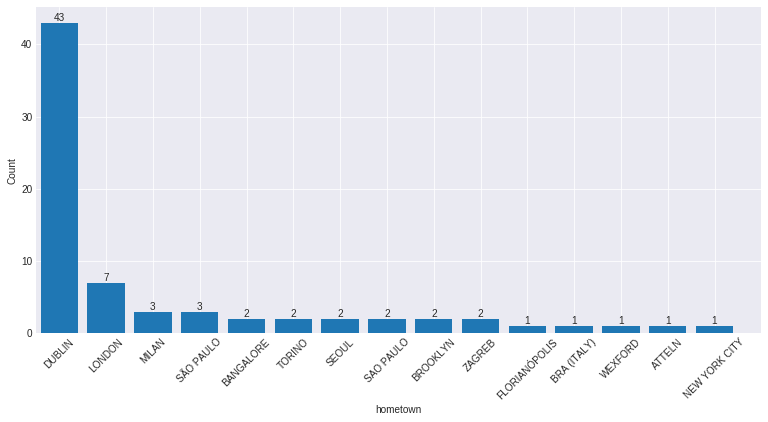

In [190]:
top_n_barplot(user_df, 'hometown')

In [61]:
user_df['first_name'] = user_df['name'].str.replace(r'(^\s+)|(\s+$)','').str.upper().str.split(' ').apply(lambda s: s[0])

## Most common names

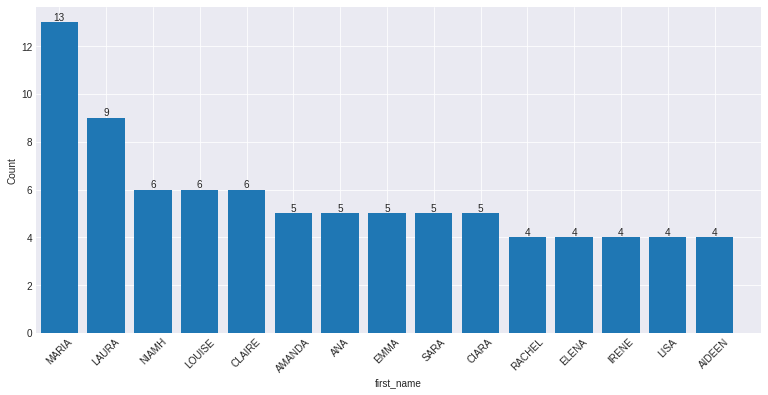

In [63]:
top_n_barplot(user_df, 'first_name')

In [76]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

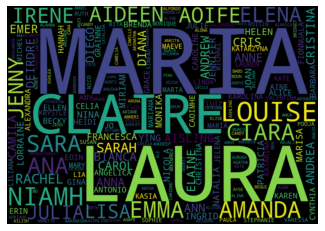

In [81]:
names_txt = ' '.join(user_df['first_name'])
wc = WordCloud(collocations=False, width=1000, height=700).generate(names_txt)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [83]:
wc.to_file("img/name_wc.png")

In [90]:
user_df

,bio,city,country,hometown,user_id,joined,lat,link,lon,name,state,status,topics,visited,joined_month,joined_year,joined_month_year,first_name
0,Engineer working at Etsy,Dublin,ie,NaN,203627719,2017-04-18 22:36:19,53.33,http://www.meetup.com/members/203627719,-6.25,Niamh Donnelly,NaN,active,15236,2019-02-19 14:48:46,4,2017,4-2017,NIAMH
1,NaN,Anyang,kr,NaN,236920397,2018-01-10 10:55:54,37.39,http://www.meetup.com/members/236920397,126.92,A Yeon Choi,NaN,active,"50881,563,26212,67622,48471,3833",2018-01-10 10:55:54,1,2018,1-2018,A
2,NaN,Dublin,ie,NaN,202430831,2019-03-23 10:51:08,53.33,http://www.meetup.com/members/202430831,-6.25,Aakanksha Rana,NaN,active,"59430,18551,65780,8476,48471,108403,682,9696,563",2019-04-08 07:36:11,3,2019,3-2019,AAKANKSHA
3,NaN,Paris,fr,NaN,129312012,2016-02-12 22:08:19,48.86,http://www.meetup.com/members/129312012,2.34,abdobim,NaN,active,"189,2260,16216,20346,21441,51642,9696,10306,10...",2016-02-14 21:20:05,2,2016,2-2016,ABDOBIM
4,NaN,Dublin,ie,NaN,242392259,2017-11-28 17:14:11,53.33,http://www.meetup.com/members/242392259,-6.25,Abheri Dutta,NaN,active,"9696,15236,1924,8476,223,6144,39173,9349,206,1...",2018-06-19 10:58:20,11,2017,11-2017,ABHERI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,NaN,Dublin,ie,NaN,215300139,2017-06-07 00:06:42,53.33,http://www.meetup.com/members/215300139,-6.25,yultuz yakup,NaN,active,"6144,36229,23884,781,206,16207,594,9300,7319,1...",2017-06-07 00:06:42,6,2017,6-2017,YULTUZ
837,NaN,Dublin,ie,NaN,204532698,2016-06-08 14:26:12,53.33,http://www.meetup.com/members/204532698,-6.25,Yvonne,NaN,active,NaN,2018-04-12 08:54:11,6,2016,6-2016,YVONNE
838,Learner,Dublin,ie,NaN,178782322,2014-10-20 18:36:18,53.33,http://www.meetup.com/members/178782322,-6.25,Zhou Xu,NaN,active,NaN,2014-11-11 20:47:30,10,2014,10-2014,ZHOU
839,NaN,Dublin,ie,ODENSE,195659013,2019-07-16 15:19:45,53.33,http://www.meetup.com/members/195659013,-6.25,Zoltán,NaN,active,"563,827,9696,10110,128595,15582,408",2019-07-18 11:12:50,7,2019,7-2019,ZOLTÁN
